# Real time OCR + NLP

## Converting Image to Text (OCR Task)

Import necessary packages

In [1]:
!pip install pytesseract opencv-python

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [4]:
import cv2
import os
import pytesseract
from PIL import Image

Now we process the image to convert to grayscale and then `pytesseract` will detect the text

In [1]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


def clean_ocr_text(raw_text):
    text = raw_text.lower()
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)         # Remove non-ASCII
    text = re.sub(r'\s+', ' ', text).strip()           # Normalize spaces
    text = re.sub(r'[\[\]\(\)\{\}<>]', '', text)       # Remove brackets
    text = re.sub(r'[^a-zA-Z0-9.,$:%\- ]', '', text)   # Clean up symbols

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return ' '.join(tokens)

[nltk_data] Downloading package punkt_tab to C:\Users\Meher Sai
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Meher Sai
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Meher Sai
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def extract_text_from_image(image_path):
    # Import required packages
    import cv2
    import pytesseract

    # Read image from which text needs to be extracted
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image {image_path}. Please check the file path and ensure the image is not corrupted.")
        return None

    # Preprocessing the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Performing OTSU threshold
    _, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    # Specify structure shape and kernel size
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

    # Applying dilation on the threshold image
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)

    # Finding contours
    contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Creating a copy of the image
    im2 = img.copy()

    extracted_text = []

    # Looping through the identified contours
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Drawing a rectangle on the copied image
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Cropping the text block for giving input to OCR
        cropped = im2[y:y + h, x:x + w]

        # Apply OCR on the cropped image
        text = pytesseract.image_to_string(cropped)

        extracted_text.append(text)

    # Clean the extracted text
    return clean_ocr_text(' '.join(extracted_text))


In [5]:
#We then read the image with text
images=cv2.imread("images_new/315.jpg")

#convert to grayscale image
gray=cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)

	
#memory usage with image i.e. adding image to memory
filename = "{}.jpg".format(os.getpid())
cv2.imwrite(filename, gray)
text = pytesseract.image_to_string(Image.open(filename))
os.remove(filename)
print(text)


»
mei 4
Sarge
ope
ase
ee
tL ae
ao we
2
<
> 2
-




In [7]:
import numpy as np
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Denoise using bilateral filter
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Adaptive Thresholding (better for non-uniform lighting)
    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 31, 10
    )

    # Morphological operations to clean small noise
    kernel = np.ones((1, 1), np.uint8)
    processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    return processed

def extract_text_from_image(image_path):
    processed_img = preprocess_image(image_path)

    # Save temporarily to disk for PIL to read
    temp_filename = "temp_ocr.png"
    cv2.imwrite(temp_filename, processed_img)

    # Extract text with pytesseract
    text = pytesseract.image_to_string(Image.open(temp_filename))

    os.remove(temp_filename)
    return text.strip()

extract_text_from_image("images_new/315.jpg")

''

Text processing of ground truth text 

In [2]:
import os
import re

def extract_text_from_file(file_path):
    combined_text = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            match = re.search(r'"(.*?)"', line)
            if match:
                text = match.group(1).strip()
                if text:
                    combined_text.append(text)
    return ' '.join(combined_text)

# Input and output folders
input_folder = 'GT_Text/'      # Folder with original text files
output_folder = 'GT_Text_modified'    # Folder where combined text files will be saved

os.makedirs(output_folder, exist_ok=True)

# Process each file
for filename in os.listdir(input_folder):
    if filename.endswith('.txt'):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        combined_text = extract_text_from_file(input_path)

        with open(output_path, 'w', encoding='utf-8') as out_file:
            out_file.write(combined_text)

        print(f"Processed: {filename}")


Processed: gt_100.txt
Processed: gt_101.txt
Processed: gt_102.txt
Processed: gt_103.txt
Processed: gt_104.txt
Processed: gt_105.txt
Processed: gt_106.txt
Processed: gt_107.txt
Processed: gt_108.txt
Processed: gt_109.txt
Processed: gt_110.txt
Processed: gt_111.txt
Processed: gt_112.txt
Processed: gt_113.txt
Processed: gt_114.txt
Processed: gt_115.txt
Processed: gt_116.txt
Processed: gt_117.txt
Processed: gt_118.txt
Processed: gt_119.txt
Processed: gt_120.txt
Processed: gt_121.txt
Processed: gt_122.txt
Processed: gt_123.txt
Processed: gt_124.txt
Processed: gt_125.txt
Processed: gt_126.txt
Processed: gt_127.txt
Processed: gt_128.txt
Processed: gt_129.txt
Processed: gt_130.txt
Processed: gt_131.txt
Processed: gt_132.txt
Processed: gt_133.txt
Processed: gt_134.txt
Processed: gt_135.txt
Processed: gt_136.txt
Processed: gt_137.txt
Processed: gt_138.txt
Processed: gt_139.txt
Processed: gt_140.txt
Processed: gt_141.txt
Processed: gt_142.txt
Processed: gt_143.txt
Processed: gt_144.txt
Processed:

## NLP Tasks

* These will be the NLP tasks we will implement:
    - **Sentiment analysis**
    - **Keyword Extraction**

### Building the Sentiment Analysis Model

#### We will use the IMDB dataset to fine-tune a DistilBERT model for sentiment analysis.

#### The *IMDB dataset* contains **25,000 movie reviews** labeled by sentiment for training and 25,000 movie reviews for testing.

#### `DistilBERT` is a smaller, faster and cheaper version of BERT. It is 40% smaller than BERT and runs 60% faster while preserving over 95% of BERT’s performance.



### 1. Activate GPU and Install Dependencies

In [3]:
!python --version

Python 3.10.16


In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
# Install required libraries
!pip install datasets transformers huggingface_hub

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


### 2. Preprocess data

In [2]:
# Load data
from datasets import load_dataset
imdb = load_dataset("imdb")

In [6]:
# Create a smaller training dataset for faster training times
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])
print(small_train_dataset[0])
print(small_test_dataset[0])

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, 

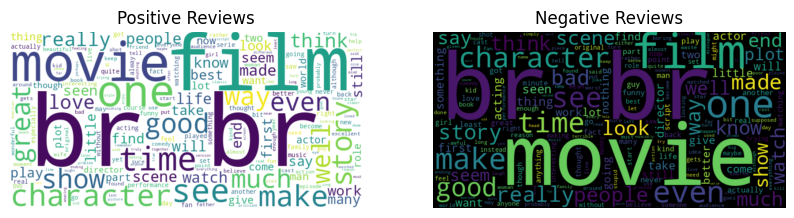

In [7]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# select positive and negative reviews
positive_text = " ".join([example["text"] for example in imdb["train"] if example["label"] == 1])
negative_text = " ".join([example["text"] for example in imdb["train"] if example["label"] == 0])

positive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color="black").generate(negative_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews")

plt.show()

Setting up a tokenizer

In [8]:
# Set DistilBERT tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)



In [10]:
# Use data_collector to convert our samples to PyTorch tensors and concatenate them with the correct amount of padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 3. Training the model

In [ ]:
!pip uninstall tensorflow keras 

In [9]:
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [11]:
# # Define DistilBERT as our base model:
# from transformers import DistilBertForSequenceClassification
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
!pip install evaluate

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [12]:
# Define the evaluation metrics 
import numpy as np
import evaluate

def compute_metrics(eval_pred):
    load_accuracy = evaluate.load("accuracy")
    load_f1 = evaluate.load("f1")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [16]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------------------------------- - 2.1/2.2 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 9.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [13]:
# Log in to your Hugging Face account 
# Get your API token here https://huggingface.co/settings/token
from huggingface_hub import notebook_login

notebook_login()

In [14]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch", 
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

C:\Users\Meher Sai K\AppData\Local\Temp\ipykernel_2820\478288466.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
# Train the model
trainer.train()


Step,Training Loss
500,0.256700
1000,0.051800
1500,0.015200


TrainOutput(global_step=1880, training_loss=0.08806871784494279, metrics={'train_runtime': 1846.469, 'train_samples_per_second': 16.247, 'train_steps_per_second': 1.018, 'total_flos': 3931071475468896.0, 'train_loss': 0.08806871784494279, 'epoch': 10.0})

In [17]:
# Compute the evaluation metrics
trainer.evaluate()

{'eval_loss': 0.7020057439804077,
 'eval_accuracy': 0.87,
 'eval_f1': 0.8721311475409836,
 'eval_runtime': 19.7434,
 'eval_samples_per_second': 15.195,
 'eval_steps_per_second': 0.962,
 'epoch': 10.0}

In [18]:
# Upload the model to the Hub
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/KMS07/finetuning-sentiment-model-3000-samples/commit/7fee7d59251d7adaa4d3ea7b88ff8ea50e7ea9d3', commit_message='End of training', commit_description='', oid='7fee7d59251d7adaa4d3ea7b88ff8ea50e7ea9d3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/KMS07/finetuning-sentiment-model-3000-samples', endpoint='https://huggingface.co', repo_type='model', repo_id='KMS07/finetuning-sentiment-model-3000-samples'), pr_revision=None, pr_num=None)

In [4]:
# Run inferences with your new model using Pipeline
from transformers import pipeline

sentiment_model = pipeline(model="KMS07/finetuning-sentiment-model-3000-samples")

Device set to use cuda:0


In [26]:
sentiment_model(["Its a good movie", "I love this movie! It was amazing!"])

[{'label': 'LABEL_1', 'score': 0.9982712268829346},
 {'label': 'LABEL_1', 'score': 0.9984152317047119}]

In [5]:
from PIL import Image
import pytesseract
import os

# Folder containing the images
image_folder = "sentiment_images"

# Iterate through each image in the folder
for image_file in os.listdir(image_folder):
    if image_file.endswith(".png"):
        image_path = os.path.join(image_folder, image_file)
    
        
        # Extract text using pytesseract
        extracted_text = extract_text_from_image(image_path)
        
        # Predict sentiment using the sentiment model
        prediction = sentiment_model([extracted_text])
        
        # Print the results
        print(f"Image: {image_file}")
        print(f"Extracted Text: {extracted_text.strip()}")
        print(f"Predicted Sentiment: {prediction[0]['label']}")
        print("-" * 50)

Image: negative_1.png
Extracted Text: thisis worstservice ive ever .
Predicted Sentiment: LABEL_0
--------------------------------------------------
Image: negative_4.png
Extracted Text: totally disappointed , waste money .
Predicted Sentiment: LABEL_0
--------------------------------------------------
Image: neutral_2.png
Extracted Text: item wasokay , nothing special .
Predicted Sentiment: LABEL_0
--------------------------------------------------
Image: neutral_5.png
Extracted Text: itsfine , job ,
Predicted Sentiment: LABEL_0
--------------------------------------------------
Image: positive_0.png
Extracted Text: absolutely love preduct itsamazing ,
Predicted Sentiment: LABEL_1
--------------------------------------------------
Image: positive_3.png
Extracted Text: highly recommend toeveryone
Predicted Sentiment: LABEL_1
--------------------------------------------------


Keyword highlighting analysis using TF-IDF

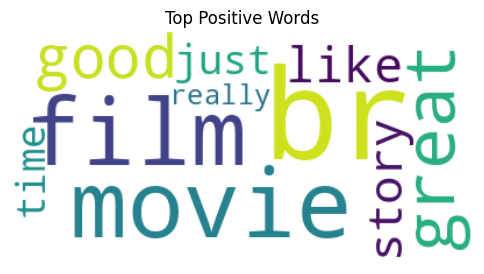

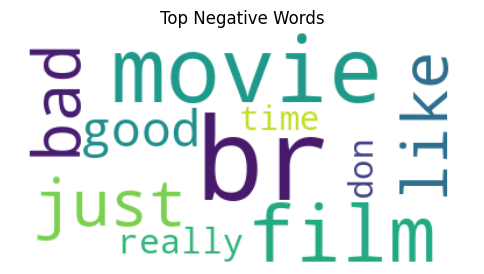

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positiveText = [example["text"] for example in imdb["train"] if example["label"] == 1]
negativeText = [example["text"] for example in imdb["train"] if example["label"] == 0]

vectorizer = TfidfVectorizer(stop_words='english')

vectorizer.fit(positiveText + negativeText)

pos_tfidf = vectorizer.transform(positiveText)
neg_tfidf = vectorizer.transform(negativeText)

def get_top_keywords(tfidf_matrix, vectorizer, top_n=10):
    avg_scores = tfidf_matrix.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    top_idx = avg_scores.argsort()[::-1][:top_n]
    return {terms[i]: avg_scores[i] for i in top_idx}

top_pos_keywords = get_top_keywords(pos_tfidf, vectorizer)
top_neg_keywords = get_top_keywords(neg_tfidf, vectorizer)


def plot_wordcloud(freq_dict, title):
    wc = WordCloud(background_color="white").generate_from_frequencies(freq_dict)
    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(top_pos_keywords, "Top Positive Words")
plot_wordcloud(top_neg_keywords, "Top Negative Words")

In [1]:
from PIL import Image, ImageDraw, ImageFont
import os
import pandas as pd

# Create a folder for images
os.makedirs("sentiment_images", exist_ok=True)

# Sample sentiment-labeled texts
data = [
    ("I absolutely love this product! It's amazing.", "positive"),
    ("This is the worst service I’ve ever had.", "negative"),
    ("The item was okay, nothing special.", "neutral"),
    ("Highly recommend this to everyone!", "positive"),
    ("Totally disappointed. Waste of money.", "negative"),
    ("It's fine, does the job.", "neutral"),
]

# Save as a CSV too
df = pd.DataFrame(data, columns=["text", "sentiment"])
df.to_csv("sentiment_labels.csv", index=False)

# Create image for each entry
font = ImageFont.load_default()

for i, (text, sentiment) in enumerate(data):
    img = Image.new('RGB', (800, 100), color=(255, 255, 255))
    d = ImageDraw.Draw(img)
    d.text((10, 25), text, fill=(0, 0, 0), font=font)

    # Save image
    img_path = f"sentiment_images/{sentiment}_{i}.png"
    img.save(img_path)

print("Images and labels saved.")

Images and labels saved.


### Keyword extraction

In [ ]:
import spacy
import pytextrank

# Load spaCy model and add TextRank to the pipeline
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank", last=True)


# Extract keywords for each sentence
sentence_keywords = []
for key in text_map:
    sent_doc = nlp(text_map[key])
    keywords = [phrase.text.lower() for phrase in sent_doc._.phrases[:5]]  # Top 3 keywords
    sentence_keywords.append((text_map[key], keywords))

# Print the sentences along with their keywords
for sentence, keywords in sentence_keywords:
    print(f"Sentence: {sentence}")
    print(f"Keywords: {keywords}")
    print("-" * 40)


Statistical analysis

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer



# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the OCR documents
tfidf_matrix = vectorizer.fit_transform(text_map.values())

# Get feature (word) names and tf-idf values
feature_names = vectorizer.get_feature_names_out()

# Display TF-IDF scores for each document
for doc_idx, doc in enumerate(text_map.values()):
    print(f"\n🔎 Top keywords in document {doc_idx+1}:")
    scores = zip(feature_names, tfidf_matrix[doc_idx].toarray()[0])
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for word, score in sorted_scores[:5]:  # top 5
        if score > 0:
            print(f"{word}: {score:.4f}")

In [ ]:
from rake_nltk import Rake



# Initialize RAKE with NLTK stopwords
rake = Rake()
rake.extract_keywords_from_text(" ".join(text_map.values()))

# Display ranked keywords/phrases
print("🔑 RAKE Keywords:")
for score, phrase in rake.get_ranked_phrases_with_scores():
    print(f"{score:.2f} - {phrase}")

In [ ]:
import yake



# Set language and max keyword length
kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=10)
keywords = kw_extractor.extract_keywords(" ".join(text_map.values()))

print("🔑 YAKE! Keywords:")
for kw, score in keywords:
    print(f"{kw} : {score:.4f}")


POS tagging

In [ ]:
import nltk
from nltk import word_tokenize, pos_tag


# Tokenize and POS tag
tokens = word_tokenize(" ".join(text_map.values()))
tags = pos_tag(tokens)

print("🔠 POS Tags:")
for word, tag in tags:
    print(f"{word}: {tag}")
